# Word detection from audio

We develop a **GRU** to detect a particular word from audio files.

Given an audio file our goal is to  files when the word "go" is uttered, if it is uttered.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

import IPython
import librosa

import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

We created a set of 10 seconds long audio files.  They consist of background noise, the word "go" and other words at random locations.

This is an example:

In [3]:
IPython.display.Audio('./data/file_example.wav')

We divide the file in 5513 segments and we extract 13 MFCC coefficients for each segment. This will be our feature vector.

In [4]:
audio, sr=librosa.load('./data/file_example.wav',44100)
X_example=librosa.feature.mfcc(audio, sr=44100, n_mfcc=13, hop_length=80)

In [5]:
X_example.shape

(13, 5513)

This means that the GRU will have 5513 input timesteps.

The number of output timesteps will be 1375 (this is becouse on the GNR we will first apply a 1D-convolution with an output of 1375 entries).
The output vector will consists of zeros, but just after "go" is detected there will be 50 consecutive ones.

In [6]:
y_example=np.load('./data/y_example.npy')
y_example

array([[0., 0., 0., ..., 0., 0., 0.]])

Let us plot this to verify where the ones are.

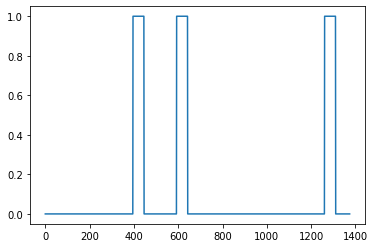

In [7]:
plt.plot(y_example[0])

The peaks correspond to the "go"'s on the audio file.

### Load Dataset

In [12]:
Y=np.load('./data/Y_train.npy')

In [13]:
Y.shape

(1000, 1375, 1)

In [14]:
X=np.load('./data/X_train.npy')

In [15]:
X.shape

(1000, 5513, 13)

### Split Dataset into training, test and valitation sets

In [16]:
X_1, X_val, y_1, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.12, random_state=42)

In [18]:
X_train.shape

(792, 5513, 13)

In [19]:
y_train.shape

(792, 1375, 1)

## Model

In [20]:
def model(input_shape):
    X_input = Input(shape = input_shape)
    X = Conv1D(128, kernel_size=15, strides=4)(X_input)                                 
    X = BatchNormalization()(X)                           
    X = Activation('relu') (X)                                
    X = Dropout(0.8)(X)                                 
    X = GRU(units = 128, return_sequences = True)(X)                                 
    X = Dropout(0.8)(X)                                
    X = BatchNormalization()(X)                                
    X = GRU(units = 128, return_sequences = True)(X)                                
    X = Dropout(0.8)(X)                                
    X = BatchNormalization()(X)                               
    X = Dropout(0.8)(X)                               
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [21]:
model = model(input_shape = (5513, 13))

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5513, 13)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1375, 128)         25088     
_________________________________________________________________
batch_normalization (BatchNo (None, 1375, 128)         512       
_________________________________________________________________
activation (Activation)      (None, 1375, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1375, 128)         0         
_________________________________________________________________
gru (GRU)                    (None, 1375, 128)         99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 128)         0     

## Training

In [23]:
opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
callback = EarlyStopping(monitor='loss', patience=3)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
callback = EarlyStopping(monitor='loss', patience=10)


In [24]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=1000, batch_size=20, callbacks=callback)

Epoch 1/1000
40/40 [==============================] - 68s 2s/step - loss: 0.5613 - accuracy: 0.7746 - val_loss: 0.3749 - val_accuracy: 0.9316
Epoch 2/1000
40/40 [==============================] - 59s 1s/step - loss: 0.2048 - accuracy: 0.9228 - val_loss: 0.4553 - val_accuracy: 0.9316
Epoch 3/1000
40/40 [==============================] - 61s 2s/step - loss: 0.1703 - accuracy: 0.9275 - val_loss: 0.4422 - val_accuracy: 0.9316
Epoch 4/1000
40/40 [==============================] - 59s 1s/step - loss: 0.1526 - accuracy: 0.9325 - val_loss: 0.4792 - val_accuracy: 0.9316
Epoch 5/1000
40/40 [==============================] - 59s 1s/step - loss: 0.1429 - accuracy: 0.9357 - val_loss: 0.4312 - val_accuracy: 0.9316
Epoch 6/1000
40/40 [==============================] - 59s 1s/step - loss: 0.1423 - accuracy: 0.9358 - val_loss: 0.4690 - val_accuracy: 0.9316
Epoch 7/1000
40/40 [==============================] - 58s 1s/step - loss: 0.1320 - accuracy: 0.9403 - val_loss: 0.2531 - val_accuracy: 0.9303
Epoch 

40/40 [==============================] - 60s 1s/step - loss: 0.0559 - accuracy: 0.9781 - val_loss: 0.1373 - val_accuracy: 0.9523
Epoch 59/1000
40/40 [==============================] - 59s 1s/step - loss: 0.0527 - accuracy: 0.9798 - val_loss: 0.1346 - val_accuracy: 0.9472
Epoch 60/1000
40/40 [==============================] - 59s 1s/step - loss: 0.0563 - accuracy: 0.9784 - val_loss: 0.1718 - val_accuracy: 0.9355
Epoch 61/1000
40/40 [==============================] - 60s 1s/step - loss: 0.0526 - accuracy: 0.9796 - val_loss: 0.2698 - val_accuracy: 0.9247
Epoch 62/1000
40/40 [==============================] - 59s 1s/step - loss: 0.0514 - accuracy: 0.9803 - val_loss: 0.1858 - val_accuracy: 0.9397
Epoch 63/1000
40/40 [==============================] - 59s 1s/step - loss: 0.0551 - accuracy: 0.9785 - val_loss: 0.2594 - val_accuracy: 0.9107
Epoch 64/1000
40/40 [==============================] - 59s 1s/step - loss: 0.0530 - accuracy: 0.9792 - val_loss: 0.3000 - val_accuracy: 0.9127
Epoch 65/1000

In [25]:
model.save('./data/model.h5')

## Evaluation

In [26]:
loss, acc = model.evaluate(X_val, y_val)
print("Validation set accuracy = ", acc)

4/4 [==============================] - 1s 277ms/step - loss: 0.1531 - accuracy: 0.9572
Validation set accuracy =  0.9571781754493713


For the example above let us see what happens.

In [27]:
x  = X_example.swapaxes(0,1)
x = np.expand_dims(x, axis=0)
y_pred=model.predict(x)

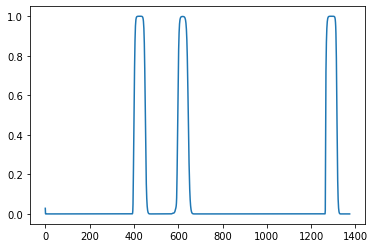

In [28]:
plt.plot(y_pred[0])